In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
import textwrap
from itertools import combinations, islice
from dateutil import parser
from datetime import datetime
from collections import Counter
from langdetect import detect
from omnibelt import load_json, save_json
import Levenshtein
from unidecode import unidecode
import unicodedata
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
import pickle as pkl

# from sklearn.cluster import DBSCAN
# import numpy as np

stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from gensim.models import KeyedVectors
from nltk.tokenize import word_tokenize
import nltk

# Download the tokenizers
# nltk.download('punkt')

# word_vectors = KeyedVectors.load_word2vec_format('/home/fleeb/Downloads/GoogleNews-vectors-negative300.bin',
# 												 binary=True)


In [2]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [3]:
root = Path('/home/fleeb/workspace/local_data/nnn')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
recs = list(recs)
len(recs)
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
by_loc = {}
by_lang = {}
by_source = {}
by_ID = {}
for article in tqdm(articles):
	by_ID[article['ID']] = article
	# article['published'] = parser.parse(article['publishedAt'])
	by_source.setdefault(article['source-name'], []).append(article)
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(articles), len(by_loc), len(by_lang)

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/4719199 [00:00<?, ?it/s]

(4719199, 54, 30)

In [45]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		elif desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))

def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'],
			'language': art['language']}
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms
_my_stop_words = {"'s", 'news'}
def is_good_word(w):
	return not all(unicodedata.category(char).startswith('P') or unicodedata.category(char).startswith('N') for char in w) and w not in stop_words and w not in _my_stop_words

In [46]:
# all_bags = pkl.load(open(root/'temp'/'all_bags.pkl', 'rb'))
all_bags_inds = pkl.load(open(root/'temp'/'all_bags_inds.pkl', 'rb'))
all_bags = {ID: Counter({w: len(inds) for w, inds in bag.items() if len(inds) and is_good_word(w)}) for ID, bag in all_bags_inds.items()}
len(all_bags), len(all_bags_inds)

(4719199, 4719199)

In [47]:
art = random.choice(articles)
view_article(art, detailed=True)

English Title: "New robotic thumb affects the brain's perception of the hand - Illivet"
Swedish Title: 'Ny robottumme påverkar hjärnans uppfattning av handen - Illivet'
Categories: <general> <health>  ---   'Sweden' (28 May21 - 29 May21)  ---  Illvet.se
English Description: Now a group of researchers has invented a robotic thumb that makes it possible to perform tasks with one hand that previously required two hands.


In [230]:

world = articles

# select articles of one language
world = by_lang['zh']

len(world)

270887

In [231]:
df = pd.DataFrame(
	[{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in tqdm([art_row(art) for art in world]) for i, inst in
	 enumerate(by_ID[row['aid']]['instances'])])
df['collectedAt'] = pd.to_datetime(df['collectedAt'])
df = df.sort_values('collectedAt')
df['date'] = df['collectedAt'].dt.date
len(df)

  0%|          | 0/270887 [00:00<?, ?it/s]

412219

In [232]:
daybags = {}
date_aids = dict(df.groupby('date')['aid'].apply(set))
for date, aIDs in tqdm(sorted(date_aids.items())):
	total = Counter()
	for aID in aIDs:
		total.update(all_bags[aID])
	daybags[date] = total
len(daybags)
dayidf = Counter()
for date, bag in tqdm(daybags.items()):
	dayidf.update(bag.keys())
dayidf = {w: np.log(len(daybags) / f) for w, f in dayidf.items()}
daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in
			tqdm(daybags.items())}
len(daytfidf)

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [233]:
target = random.choice(list(daytfidf.keys()))
importances = daytfidf[target]
counts = daybags[target]
print(target.strftime('%d %b %Y'))

03 Jun 2021


In [235]:
print(tabulate([(w, f, counts[w]) for w, f in importances.most_common(10)]))

---------  -----------  --
june       0.00109679   21
licenses   0.000998996   2
jbs        0.000981177   3
qingluo    0.000884037   2
pingzhou   0.000884037   2
slowpoke   0.000884037   2
amc        0.000881052   4
stopwatch  0.000769078   2
kingston   0.000742767   4
alluring   0.000732069   2
---------  -----------  --


In [237]:
dayidx = []
dates = []
origin = min(daytfidf)
for day in sorted(daytfidf):
	dates.append(day)
	dayidx.append((day - origin).days)
dayidx = np.array(dayidx)
dates = np.array(dates)
date2day = {d: day for d, day in zip(dates, dayidx)}
dayidx[-1]

479

In [238]:
# deltadays = 57
# sel = (dayidx >= deltadays) & (dayidx <= dayidx[-1] - deltadays)
m, d = 10, 3
sel = np.array([datetime(2020, m, d).date() <= date < datetime(2021, m, d).date() for date in dates]).astype(bool)
seldates = dates[sel]
selidx = dayidx[sel]
sum(sel), seldates[0], seldates[-1]

(317, datetime.date(2020, 10, 3), datetime.date(2021, 10, 2))

In [239]:
target = random.choice(seldates)
importances = daytfidf[target]
counts = daybags[target]
print(target.strftime('%d %b %Y'))

03 Feb 2021


In [241]:
# print(tabulate([(w, f, counts[w]) for w, f in importances.most_common(20)]))

In [242]:
topwordsperday = {date2day[day]: [w for w, f in daytfidf[day].most_common(20)] for day in tqdm(seldates)}
alltopwords = {w for ws in topwordsperday.values() for w in ws}
len(topwordsperday), len(alltopwords)

  0%|          | 0/317 [00:00<?, ?it/s]

(317, 4294)

In [243]:
token = random.choice(list(alltopwords))
# token = 'covid'
token

'jianming'

In [246]:
imps = np.array([daytfidf[d][token] for d in dates])
cnts = np.array([daybags[d][token] for d in dates])

sub = pd.DataFrame({'date': dates, 'importance': imps, 'counts': cnts})
# sub

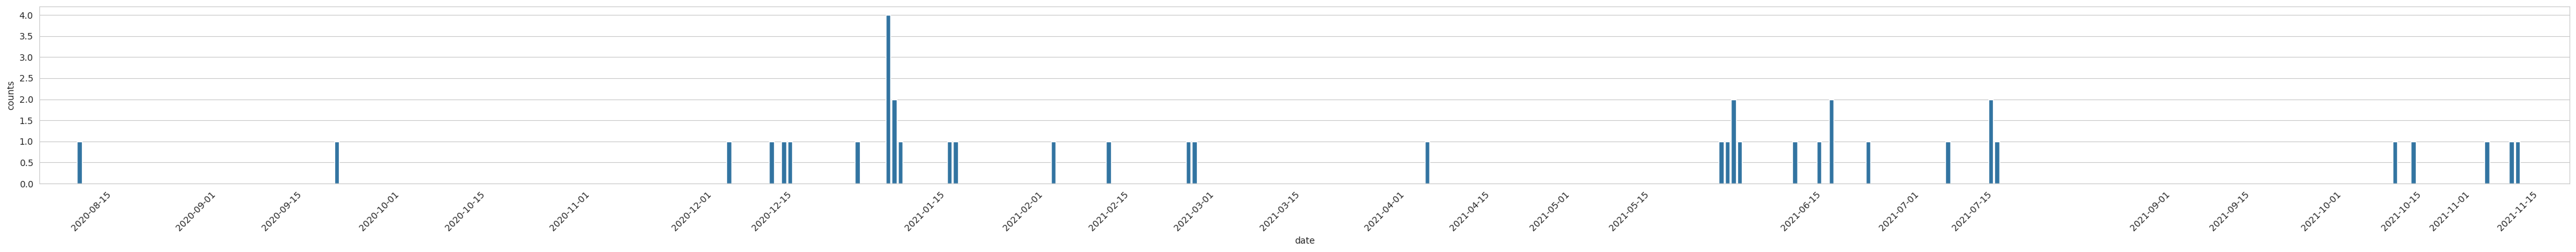

In [247]:
plt.figure(figsize=(40, 4))
sns.barplot(data=sub, x='date', y='counts');
plt.xticks(ticks=[i for i, date in enumerate(sub['date']) if date.day in {1, 15}], 
           labels=[date.strftime('%Y-%m-%d') for date in sub['date'] if date.day in {1, 15}],
           rotation=45)
plt.tight_layout();

In [250]:
def compute_peak_shape(tokens, back_lim=30, forw_lim=30, pbar=True):
	word_dens = Counter()
	word_nums = Counter()
	
	for token in tqdm(tokens) if pbar else tokens:
		imps = np.array([daytfidf[d][token] for d in dates])
		cnts = np.array([daybags[d][token] for d in dates])
		
		peak_deltas = dayidx - dayidx[np.argmax(cnts)]
		
		for delta, imp, cnt in zip(peak_deltas, imps, cnts):
			if -back_lim <= delta <= forw_lim:
				word_dens[delta] += 1
				word_nums[delta] += cnt
	
	word_deltas = {delta: word_nums[delta] / word_dens[delta] for delta in word_dens}
	return np.array(sorted(word_deltas.items())).T

  0%|          | 0/4294 [00:00<?, ?it/s]

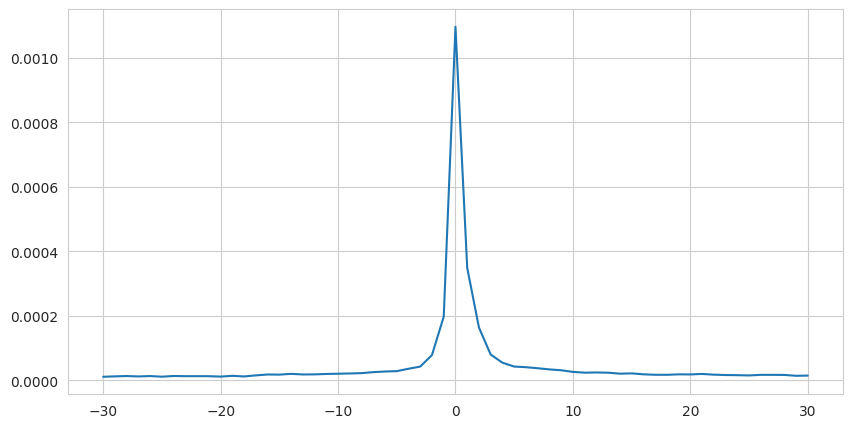

In [251]:
X, Y = compute_peak_shape(alltopwords)
plt.figure(figsize=(10, 5))
plt.plot(X, Y);
# plt.gca().minorticks_on()
# plt.tight_layout();

  0%|          | 0/3108 [00:00<?, ?it/s]

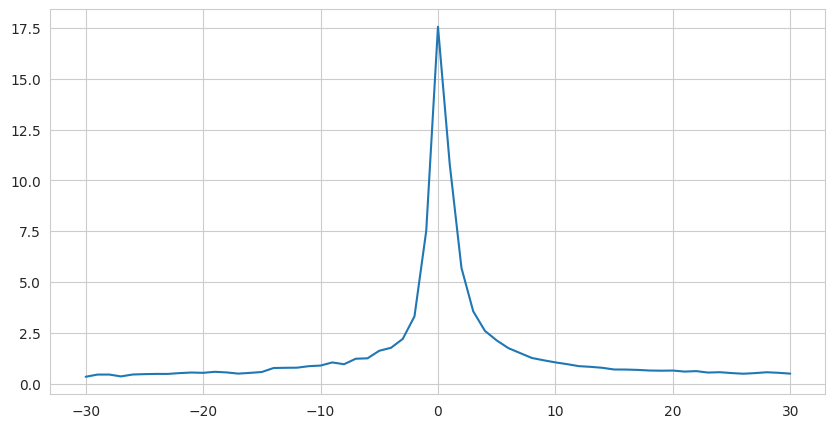

In [227]:
X, Y = compute_peak_shape(alltopwords)
plt.figure(figsize=(10, 5))
plt.plot(X, Y);
# plt.gca().minorticks_on()
# plt.tight_layout();

In [254]:
def compute_peak_shape_from_world(world, numtop=20, back_lim=30, forw_lim=30):
	df = pd.DataFrame(
		[{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in ([art_row(art) for art in world]) for i, inst in
		 enumerate(by_ID[row['aid']]['instances'])])
	df['collectedAt'] = pd.to_datetime(df['collectedAt'])
	df = df.sort_values('collectedAt')
	df['date'] = df['collectedAt'].dt.date
	len(df)
	daybags = {}
	date_aids = dict(df.groupby('date')['aid'].apply(set))
	for date, aIDs in (sorted(date_aids.items())):
		total = Counter()
		for aID in aIDs:
			total.update(all_bags[aID])
		daybags[date] = total
	len(daybags)
	dayidf = Counter()
	for date, bag in (daybags.items()):
		dayidf.update(bag.keys())
	dayidf = {w: np.log(len(daybags) / f) for w, f in dayidf.items()}
	daytotals = {d: sum(bag.values()) for d, bag in daybags.items()}
	daytfidf = {day: Counter({w: f / daytotals[day] * dayidf[w] for w, f in bag.items()}) for day, bag in
				(daybags.items())}
	len(daytfidf)
	# print(tabulate([(w, f, counts[w]) for w, f in importances.most_common(10)]))
	dayidx = []
	dates = []
	origin = min(daytfidf)
	for day in sorted(daytfidf):
		dates.append(day)
		dayidx.append((day - origin).days)
	dayidx = np.array(dayidx)
	dates = np.array(dates)
	date2day = {d: day for d, day in zip(dates, dayidx)}
	dayidx[-1]
	# deltadays = 57
	# sel = (dayidx >= deltadays) & (dayidx <= dayidx[-1] - deltadays)
	m, d = 10, 3
	sel = np.array([datetime(2020, m, d).date() <= date < datetime(2021, m, d).date() for date in dates]).astype(bool)
	seldates = dates[sel]
	selidx = dayidx[sel]
	sum(sel), seldates[0], seldates[-1]
	# print(tabulate([(w, f, counts[w]) for w, f in importances.most_common(20)]))
	topwordsperday = {date2day[day]: [w for w, f in daytfidf[day].most_common(numtop)] for day in (seldates)}
	alltopwords = {w for ws in topwordsperday.values() for w in ws}
	len(topwordsperday), len(alltopwords)
	
	def compute_peak_shape(tokens, pbar=True):
		word_dens = Counter()
		word_nums = Counter()
		
		for token in (tokens) if pbar else tokens:
			imps = np.array([daytfidf[d][token] for d in dates])
			cnts = np.array([daybags[d][token] for d in dates])
			
			peak_deltas = dayidx - dayidx[np.argmax(cnts)]
			
			for delta, imp, cnt in zip(peak_deltas, imps, cnts):
				if -back_lim <= delta <= forw_lim:
					word_dens[delta] += 1
					word_nums[delta] += cnt
		
		word_deltas = {delta: word_nums[delta] / word_dens[delta] for delta in word_dens}
		return np.array(sorted(word_deltas.items())).T
	
	return compute_peak_shape(alltopwords)

In [256]:

world = articles

# select articles of one language
world = by_lang['zh']

len(world)

270887

In [266]:
langcounts = Counter(dict((l, len(arts)) for l, arts in by_lang.items()))
langs, _ = zip(*langcounts.most_common(10))
# print(tabulate(langcounts.most_common(10)))

('en', 'es', 'fr', 'zh', 'de', 'pt', 'ar', 'id', 'it', 'tr')

In [267]:
freqs = {}

for lang in tqdm(langs):
	X, Y = compute_peak_shape_from_world(by_lang[lang], numtop=10, back_lim=30, forw_lim=30)
	freqs[lang] = Y

  0%|          | 0/10 [00:00<?, ?it/s]

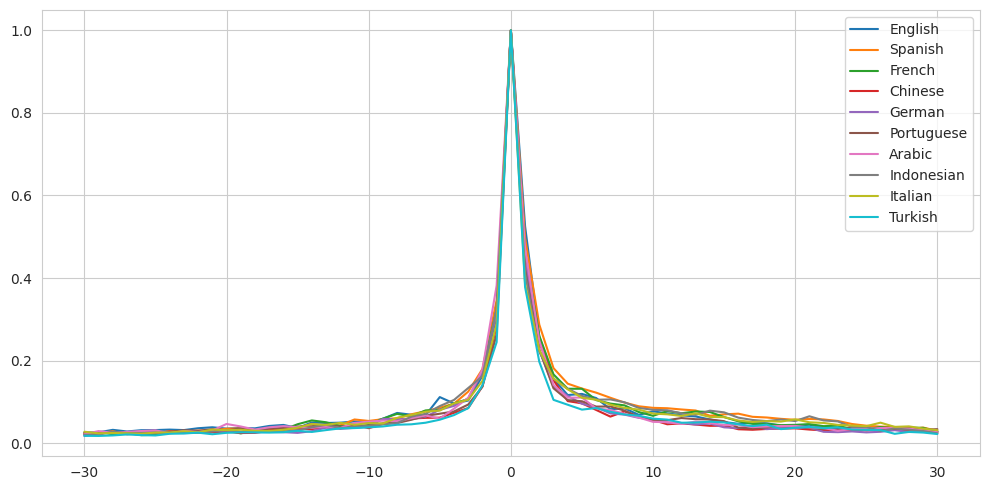

In [271]:
# plt.tight_layout();

# X, Y = compute_peak_shape_from_world(by_lang['zh'], numtop=10, back_lim=30, forw_lim=30)
plt.figure(figsize=(10, 5))

for l in langs:
	plt.plot(X, freqs[l]/max(freqs[l]), label=lang_names[l]);

plt.legend();
plt.tight_layout();

In [252]:
aids = list(by_ID)
len(aids)

4719199